# Neural inference for SIRS model

In this notebook we learn constant and non-constant parameters from (noisy) observations of the S-I-R-S model; similar to the SIR model, three comparments of susceptible, infected, and recovered agents interact via
$$S \overset{k_I}{\longrightarrow} I \overset{k_R}{\longrightarrow} R \overset{k_S}{\longrightarrow} S.$$
The difference is that now, agents can lose their immunity and move back into the `susceptible' comparment with probability $k_S$. The system of ODEs thus reads:
$$ \begin{gather} \partial_t S = -k_I SI + k_S R \\ \partial_t I = k_I SI - k_R R \\ \partial_t R = k_R I - k_S R \end{gather}$$

In [83]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch

# Local import
from include.neural_net import NeuralNet

# Uniform plot styles
from matplotlib import patches
from matplotlib.gridspec import GridSpec

%matplotlib notebook
%matplotlib inline

In [2]:
# Generate the data X and solve the ode
def generate_SIRS_data(init_state: torch.Tensor,
                      *,
                      k_I: torch.Tensor,
                      k_R: torch.Tensor,
                      k_S: torch.Tensor,
                      num_steps: int,
                      dt: float = 0.01,
                      noise: float = 0,
) -> torch.Tensor:

    """ Forward Euler solver for the SIR model. Parameters can be constant or a time series."""

    res = [init_state]
    for t in range(num_steps):
        _k_I = k_I if k_I.dim() == 0 else k_I[t]
        _k_R = k_R if k_R.dim() == 0 else k_R[t]
        _k_S = k_S if k_S.dim() == 0 else k_S[t]
        res.append(
            torch.clip(res[-1] + torch.stack(
                [
                    -_k_I * res[-1][0]* res[-1][1] + _k_S * res[-1][-1],
                    _k_I * res[-1][0] * res[-1][1] - _k_R * res[-1][1],
                    _k_R * res[-1][1] - _k_S*res[-1][-1]
                ]
            ) * dt, 0, 1)
        )

    # Return the noisy time series, if given
    X = torch.stack(res)
    if noise > 0:
        return torch.normal(X, noise * X)
    else:
        return X

## Learn constant parameters
We start with the simple case of learning a vector of constant parameters from a single, noisy dataset.

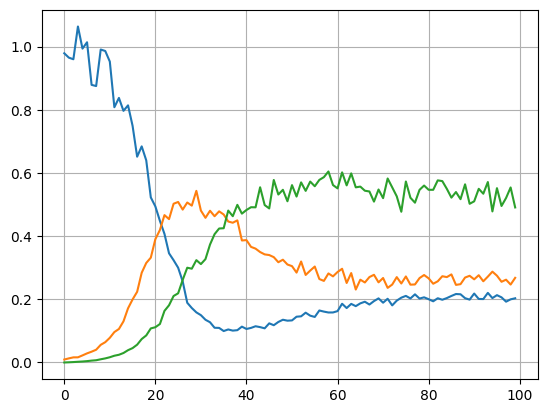

In [4]:
# Generate some training data
dt = torch.tensor(0.03)
num_steps = 100

# Constant parameters
const_params = dict(k_I=torch.tensor(10.0), k_R=torch.tensor(2.0), k_S=torch.tensor(1.0))

# Generate training data from some initial state. We store everything in a dictionary unique to our specific example.
const_data = dict(X=generate_SIRS_data(torch.tensor([0.99, 0.01, 0]), num_steps=num_steps-1, dt=dt, noise=0.05, **const_params))

plt.plot(const_data['X'])
plt.grid()

In [5]:
# Train the neural network to learn the constant parameters from L observations
const_data.update(dict(X_train = const_data['X'].flatten(), Y_train = const_data['X']))
const_data['NN'] = NeuralNet(
    input_size = const_data['X_train'].shape[0], # Input entire time series
    output_size = 3, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training loss and parameter estimates
const_data.update(dict(loss=[], param_ests=[]))

In [6]:
# Train
N_epochs = 200
for i in (pbar := tqdm.trange(N_epochs)):

    # Make a prediction from the time series
    pred = const_data['NN'](const_data['X_train'])

    # Generate a time series
    X_pred = generate_SIRS_data(const_data['Y_train'][0], k_I = pred[0], k_R=pred[1], k_S=pred[2], num_steps = len(const_data['Y_train'])-1, dt=dt)

    # Calculate the loss
    loss = torch.nn.functional.mse_loss(X_pred, const_data['Y_train'])
    loss.backward()
    const_data['NN'].optimizer.step()
    const_data['NN'].optimizer.zero_grad()
    const_data['loss'].append(loss.detach())
    const_data['param_ests'].append(pred.detach())
    pbar.set_description(f"Loss: {loss:>.4g}")

Loss: 0.0004233: 100%|██████████| 200/200 [00:02<00:00, 94.01it/s]


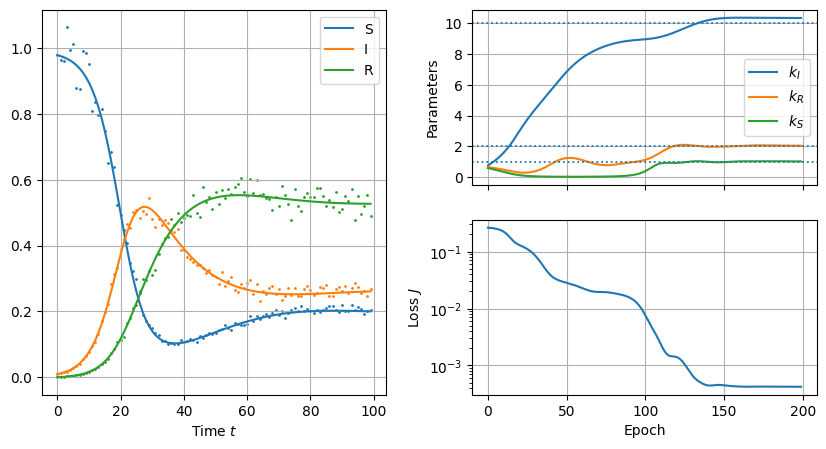

In [28]:
# Make a prediction
pred = const_data['NN'](const_data['X_train']).detach()
X_pred = generate_SIRS_data(const_data['X'][0], k_I = pred[0], k_R=pred[1], k_S=pred[2], num_steps = len(const_data['X'])-1, dt=dt)

# Plot the data and prediction
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, wspace=0.25)
ax1 = fig.add_subplot(gs[0:2, 0])
for i, label in enumerate(['S', 'I', 'R']):
    _s = ax1.scatter(torch.arange(len(const_data['X'])), const_data['X'][:, i], s=1)
    _l = ax1.plot(X_pred[:, i], label=label)
ax1.legend()
ax1.set(xlabel='Time $t$')
ax1.grid()

# Plot the parameter estimates
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(torch.stack(const_data['param_ests'])[:, 0], label='$k_I$')
ax2.plot(torch.stack(const_data['param_ests'])[:, 1], label='$k_R$')
ax2.plot(torch.stack(const_data['param_ests'])[:, 2], label='$k_S$')

ax2.legend()
ax2.axhline(const_params['k_I'], ls='dotted', lw=1.3)
ax2.axhline(const_params['k_R'], ls='dotted', lw=1.3)
ax2.axhline(const_params['k_S'], ls='dotted', lw=1.3)
ax2.grid()

ax2.set(ylabel='Parameters')
plt.setp(ax2.get_xticklabels(), visible=False)

# Plot the loss
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)
ax3.plot(const_data['loss'])
ax3.set(yscale='log', xlabel='Epoch', ylabel='Loss $J$')
ax3.grid()

## Learn ensemble of constant parameters
This is nice but boring — we could have just used an optimiser. What if we have an ensemble of datasets, and wish to learn the constants for each: how well can we extrapolate to new data?

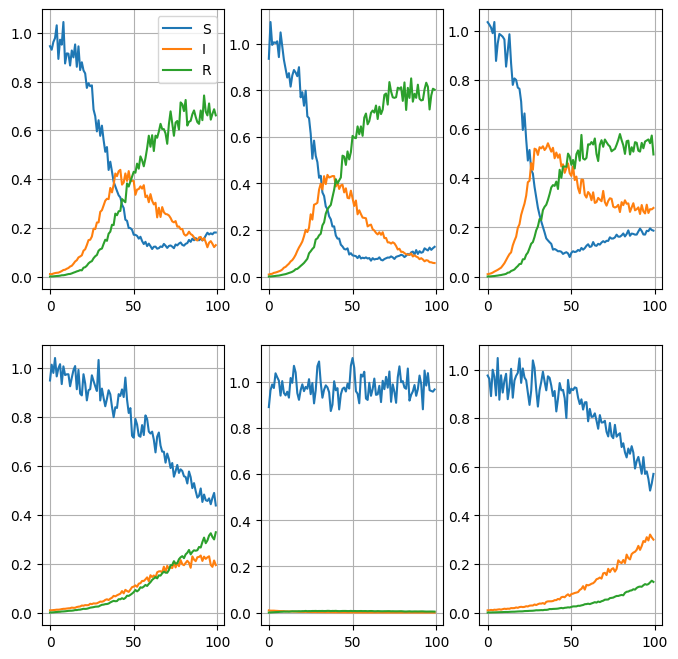

In [26]:
# Generate an ensemble of datasets
n_ensemble = 6
n_train = 4
ensemble_params = dict(params=[dict(k_I=10.0*torch.rand(1).squeeze(), k_R=2.0*torch.rand(1).squeeze(), k_S=torch.rand(1).squeeze()) for _ in range(n_ensemble)])

# Generate training data. We store everything in a dictionary unique to our specific example.
ensemble_data = dict(data=[dict(X=generate_SIRS_data(const_data['X'][0], num_steps=num_steps-1, dt=dt, noise=0.05, **_p)) for _p in ensemble_params['params']])

fig, axs = plt.subplots(figsize=(8, 8), ncols=3, nrows=2)
for idx, _d in enumerate(ensemble_data['data']):
    axs.flatten()[idx].plot(_d['X'], label=['S', 'I', 'R'])
    axs.flatten()[idx].grid()
axs.flatten()[0].legend()

In [29]:
# Train the neural network to learn the constant parameters from each dataset in the training set
for _d in ensemble_data['data']:
    _d.update(dict(X_train = _d['X'].flatten(), Y_train = _d['X']))

ensemble_data.update(dict(NN=NeuralNet(
    input_size = ensemble_data['data'][0]['X_train'].shape[0], # Input entire time series
    output_size = 3, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)))

# Store the training loss and parameter estimates
ensemble_data.update(dict(loss=[], param_ests=[]))

In [30]:
# Train
N_epochs = 1000
for i in (pbar := tqdm.trange(N_epochs)):

    loss = torch.tensor(0.0)
    for ds in ensemble_data['data'][:n_train]:

        # Make a prediction from the time series
        pred = ensemble_data['NN'](ds['X_train'])

        # Generate a time series
        X_pred = generate_SIRS_data(ds['Y_train'][0], k_I = pred[0], k_R=pred[1], k_S=pred[2], num_steps = len(ds['Y_train'])-1, dt=dt)

        # Calculate the loss
        loss = loss + torch.nn.functional.mse_loss(X_pred, ds['Y_train'])

    loss.backward()
    ensemble_data['NN'].optimizer.step()
    ensemble_data['NN'].optimizer.zero_grad()
    ensemble_data['loss'].append(loss.detach())
    ensemble_data['param_ests'].append(pred.detach())
    pbar.set_description(f"Loss: {loss:>.4g}")

Loss: 0.002754: 100%|██████████| 1000/1000 [00:35<00:00, 27.86it/s]


<Axes: >

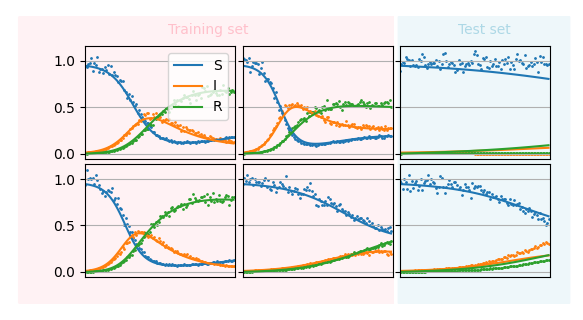

In [50]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(6, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
for idx, _d in enumerate(ensemble_data['data']):

    # Plot the true data
    for j in range(3):
        axs.transpose(1, 0).flatten()[idx].scatter(torch.arange(len(_d['X'])), _d['X'][:, j], s=1)

    # Make a prediction from the time series
    pred = ensemble_data['NN'](_d['X_train']).detach()
    axs.transpose(1, 0).flatten()[idx].plot(
        generate_SIRS_data(ensemble_data['data'][0]['X'][0], k_I = pred[0], k_R=pred[1], k_S=pred[2], num_steps = len(ds['Y_train'])-1, dt=dt), label=['S', 'I', 'R']
    )
    axs.flatten()[idx].patch.set_alpha(0.)
axs[0, 0].legend()
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_xlim(0, len(ensemble_data['data'][0]['X']))
    ax.grid()

box_1 = fig.add_axes([0, 0, 0.66, 1], zorder=-2)
box_1.xaxis.set_visible(False)
box_1.yaxis.set_visible(False)
for s in ['top', 'bottom', 'right', 'left']:
    box_1.spines[s].set_visible(False)
rect = patches.FancyBboxPatch((0.02, 0.02), 0.96, 0.96, linewidth=0, facecolor='pink', alpha=0.2, transform=box_1.transAxes, boxstyle='Round, pad=0, rounding_size=0.005')
box_1.add_patch(rect)
box_1.text(0.5, 0.92, 'Training set', color='pink', ha='center')
fig.add_axes(box_1)

box_2 = fig.add_axes([0.64, 0, 0.3, 1], zorder=-2)
box_2.xaxis.set_visible(False)
box_2.yaxis.set_visible(False)
for s in ['top', 'bottom', 'right', 'left']:
    box_2.spines[s].set_visible(False)
rect = patches.FancyBboxPatch((0.02, 0.02), 0.96, 0.96, linewidth=0, facecolor='lightblue', alpha=0.2, transform=box_2.transAxes, boxstyle='Round, pad=0, rounding_size=0.005')
box_2.add_patch(rect)
box_2.text(0.5, 0.92, 'Test set', color='lightblue', ha='center')
fig.add_axes(box_2)

## Seasonal SIRS model
Now we let the parameters be a function of some external forcing, e.g. temperature. The parameters are now implicit functions of time. We train the neural network on one cycle of the parameters, and see if learns the correct pattern.

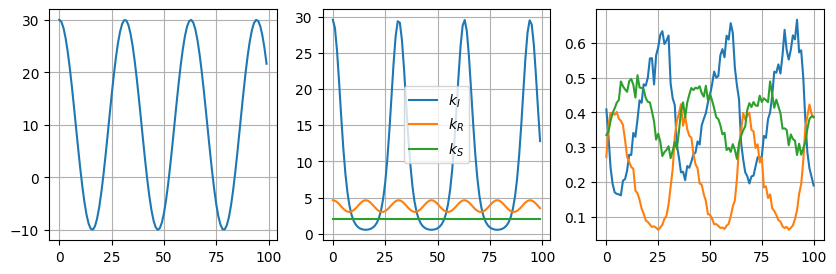

In [85]:
# Make parameters a function of the external temperature
temp = 20*torch.cos(0.2*torch.arange(0, 100, 1))+10

# Parameters are some arbitrary function of the temperature
seasonal_params=dict(k_I=4*torch.exp(0.1*(temp-10)),
                     k_R=3*torch.cosh(0.05*(temp-10)),
                     k_S=2*torch.cosh(0.*(temp-10)))

seasonal_data=dict(X=generate_SIRS_data(torch.tensor([0.8, 0.1, 0.1]), num_steps=len(temp), dt=dt, noise=0.05, **seasonal_params))
seasonal_data=dict(X=generate_SIRS_data(seasonal_data['X'][-6], num_steps=len(temp), dt=dt, noise=0.05, **seasonal_params))

fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

axs[0].plot(temp)
axs[1].plot(seasonal_params['k_I'], label='$k_I$')
axs[1].plot(seasonal_params['k_R'], label='$k_R$')
axs[1].plot(seasonal_params['k_S'], label='$k_S$')
axs[1].legend()
for ax in axs:
    ax.grid()
axs[2].plot(seasonal_data['X'])

In [58]:
# Train on a portion of the data
L = len(seasonal_data['X']) // 3
seasonal_data.update(dict(X_train=temp[:L].reshape(-1, 1), Y_train=seasonal_data['X'][:L]))

# Initialise the neural network
seasonal_data['NN'] = NeuralNet(
    input_size = 1, # Temperature
    output_size = 3, # Number of parameters
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training data
seasonal_data['loss'] = []

In [59]:
# Train
for i in (pbar := tqdm.trange(6000)):

    # Make a prediction
    pred = seasonal_data['NN'](seasonal_data['X_train'])

    # Generate a time series
    X_pred = generate_SIRS_data(seasonal_data['Y_train'][0], k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2],
                                              num_steps=seasonal_data['X_train'].shape[0]-1, dt=dt)

    # Calculate gradient of loss
    loss = torch.nn.functional.mse_loss(X_pred, seasonal_data['Y_train'])
    loss.backward()

    # Step
    seasonal_data['NN'].optimizer.step()
    seasonal_data['NN'].optimizer.zero_grad()

    seasonal_data['loss'].append(loss.detach())
    pbar.set_description(f"Loss: {loss.detach():>.5g}")

Loss: 0.00029076: 100%|██████████| 6000/6000 [00:25<00:00, 238.05it/s]


Text(0.7, 0.8, 'Predict')

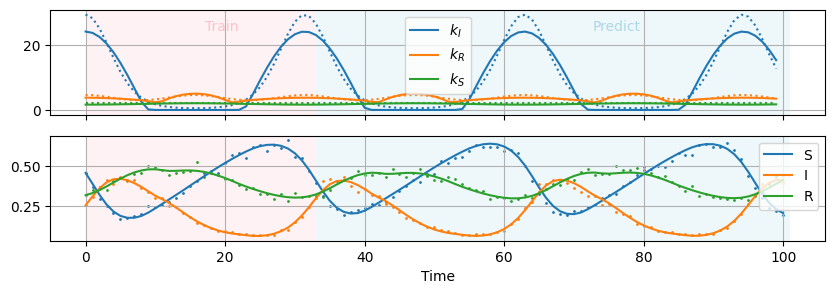

In [82]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True)

pred = seasonal_data['NN'](temp.reshape(-1, 1)).detach()
X_pred = generate_SIRS_data(seasonal_data['Y_train'][0], k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2], num_steps=seasonal_data['X'].shape[0]-1, dt=dt)
axs[0].plot(seasonal_params['k_I'], c='C0', ls='dotted')
axs[0].plot(seasonal_params['k_R'], c='C1', ls='dotted')
axs[0].plot(seasonal_params['k_S'], c='C2', ls='dotted')
axs[1].plot(X_pred, label=['S', 'I', 'R'])
for i, label in enumerate(['$k_I$', '$k_R$', '$k_S$']):
    axs[0].plot(pred[:, i], c=f'C{i}', label=label)
    axs[1].scatter(torch.arange(len(seasonal_data['X'])), seasonal_data['X'][:, i], s=1)
for ax in axs:
    ax.axvspan(0, len(seasonal_data['X_train']), color='pink', alpha=0.2, zorder=-2, lw=0)
    ax.axvspan(len(seasonal_data['X_train']), len(seasonal_data['X']), color='lightblue', alpha=0.2, zorder=-2, lw=0)
    ax.grid()
axs[0].legend()
axs[1].legend()
axs[1].set(xlabel='Time')
axs[0].text(0.2, 0.8, 'Train', c='pink', transform=axs[0].transAxes, zorder=3)
axs[0].text(0.7, 0.8, 'Predict', c='lightblue', transform=axs[0].transAxes, zorder=3)

## Seasonal SIRS with time-dependent parameters
Now we let the infection and recovery rates also be explicit functions of time, e.g. using a decay rate.

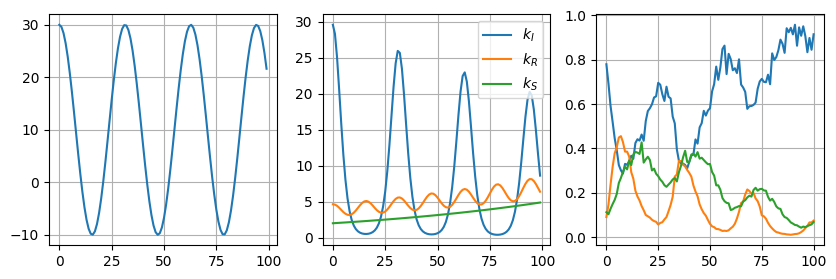

In [87]:
# Parameters are some arbitrary function of the temperature
seasonal_params_rnn=copy.deepcopy(seasonal_params)
seasonal_params_rnn['k_I'] *= torch.exp(-0.004*torch.arange(len(temp)))
seasonal_params_rnn['k_R'] *= torch.exp(0.006*torch.arange(len(temp)))
seasonal_params_rnn['k_S'] *= torch.exp(0.009*torch.arange(len(temp)))

seasonal_data_rnn=dict(X=generate_SIRS_data(torch.tensor([0.8, 0.1, 0.1]), num_steps=len(temp), dt=dt, noise=0.05, **seasonal_params_rnn))

fig, axs = plt.subplots(ncols=3, figsize=(10, 3))

axs[0].plot(temp)
axs[1].plot(seasonal_params_rnn['k_I'], label='$k_I$')
axs[1].plot(seasonal_params_rnn['k_R'], label='$k_R$')
axs[1].plot(seasonal_params_rnn['k_S'], label='$k_S$')
axs[1].legend()
for ax in axs:
    ax.grid()
axs[2].plot(seasonal_data_rnn['X'])

We learn the parameters using a recurrent neural network with a single hidden dimension (the time). This time, we train on two cycles.

In [88]:
# Train on half the data
L_2 = 2*len(seasonal_data['X']) // 3
seasonal_data_rnn.update(dict(X_train=temp[:L_2], Y_train=seasonal_data_rnn['X'][:L_2]))

# Initialise the neural network
seasonal_data_rnn['NN'] = NeuralNet(
    input_size = 2, # Temperature and hidden state
    output_size = 4, # Number of parameters and hidden state
    num_layers = 1,
    nodes_per_layer={"default": 6},
    activation_funcs={"default": "softplus"},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training data
seasonal_data_rnn['loss'] = []

In [89]:
# Train
for i in (pbar := tqdm.trange(3000)):

    # Recursively make a prediction; the initial hidden state is 0
    h_t = torch.tensor(0.0)
    pred = []
    for t in range(len(seasonal_data_rnn['X_train'])):
        _pred = seasonal_data_rnn['NN'](torch.concat([seasonal_data_rnn['X_train'][[t]], h_t.unsqueeze(0)]))
        pred.append(_pred[:3])
        h_t = _pred[-1]
    pred=torch.stack(pred)

    # Generate a time series
    X_pred = generate_SIRS_data(seasonal_data_rnn['Y_train'][0], k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2],
                                               num_steps=seasonal_data_rnn['X_train'].shape[0]-1, dt=dt)

    # Calculate gradient of loss
    loss = torch.nn.functional.mse_loss(X_pred, seasonal_data_rnn['Y_train'])
    loss.backward()

    # Step
    seasonal_data_rnn['NN'].optimizer.step()
    seasonal_data_rnn['NN'].optimizer.zero_grad()

    seasonal_data_rnn['loss'].append(loss.detach())
    pbar.set_description(f"Loss: {loss.detach():>.5g}")

Loss: 0.00046461: 100%|██████████| 3000/3000 [00:38<00:00, 78.28it/s]


Text(0.75, 0.8, 'Predict')

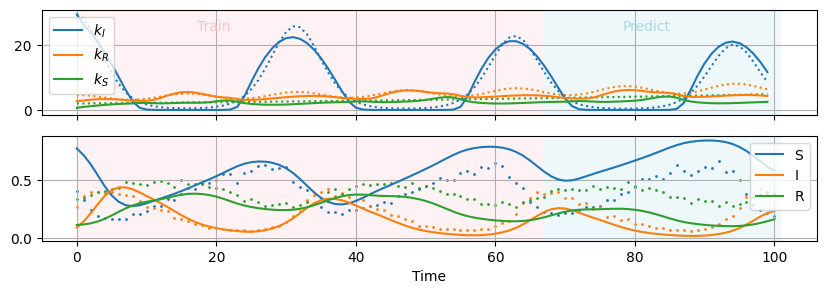

In [101]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True)

# Make a recurrent prediction
h_t = torch.tensor(0.0)
pred = []
for t in range(len(seasonal_data_rnn['X'])-1):
    _pred = seasonal_data_rnn['NN'](torch.concat([temp[[t]], h_t.unsqueeze(0)])).detach()
    pred.append(_pred[:3])
    h_t = _pred[-1]
pred=torch.stack(pred)

X_pred = generate_SIRS_data(seasonal_data_rnn['Y_train'][0], k_I = pred[:, 0], k_R=pred[:, 1], k_S=pred[:, 2], num_steps=seasonal_data_rnn['X'].shape[0]-1, dt=dt)
axs[0].plot(seasonal_params_rnn['k_I'], ls='dotted')
axs[0].plot(seasonal_params_rnn['k_R'], ls='dotted')
axs[0].plot(seasonal_params_rnn['k_S'], ls='dotted')
axs[1].plot(X_pred, label=['S', 'I', 'R'])
for i, label in enumerate(['$k_I$', '$k_R$', '$k_S$']):
    axs[0].plot(pred[:, i], c=f'C{i}', label=label)
    axs[1].scatter(torch.arange(len(seasonal_data_rnn['X'])), seasonal_data['X'][:, i], s=1)

for ax in axs:
    ax.axvspan(0, len(seasonal_data_rnn['X_train']), color='pink', alpha=0.2, zorder=-2, lw=0)
    ax.axvspan(len(seasonal_data_rnn['X_train']), len(seasonal_data_rnn['X']), color='lightblue', alpha=0.2, zorder=-2, lw=0)
    ax.grid()
    ax.legend()
axs[1].set(xlabel='Time')
axs[0].text(0.2, 0.8, 'Train', c='pink', transform=axs[0].transAxes, zorder=3)
axs[0].text(0.75, 0.8, 'Predict', c='lightblue', transform=axs[0].transAxes, zorder=3)